In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Attentionは効果的で重要なテクニック

# まとめ
Attentionの仕組みを，seq2seq上で実装し，効果を確かめ，先端の応用について学んだ．  
- Attention
    - 翻訳元と翻訳先の単語があるように，時系列データ間には対応関係が存在することが多くある．  
    - Attentionはその対応関係を学ぶ．  
    - 対応関係を学ぶため，EncoderはLSTMの全ての時刻の出力データをDecoderに渡す．
    - ベクトルの内積などによる類似度を使った重み付き和ベクトルによって，対応する単語を選択
    - Attentionの処理は微分可能であるため，誤差逆伝播法で学習が可能
    - 日付変換問題では，従来のseq2seqよりも格段に早く学習した．
    - 算出される重み(確率)を可視化することで，入出力の対応関係を見ることができる．  
- Attentionに関するテクニック
    - 双方向RNN,双方向LSTM
        - 逆方向のTimeLSTMと順方向のTimeLSTMの出力を結合
    - Attentionレイヤを別のところに挟んでみる
        - TimeLSTMの各時刻の間など
    - seq2seqを深層化
        - モデルの複雑化による過学習を防ぐため，Skipコネクションなどを利用する
            - Skipコネクション：層の出力を層をまたいで先のノードに渡し，加算する
- Attentionの応用
    - Google Neural Machine Translation(GNMT)
        - NNによって人間に近い精度を持ったGoogleの翻訳システム
    - Transformer
        - Self-Attention: 1つの時系列データを自分の入力と時系列の最初に渡す層
        - LSTMではなくすべてをAttentionによって構成することで並列化が可能になり素早く学習できる
        - GNMTを凌駕
    - Neural Turing Machine(NTM)
        - 外部メモリによるNNの拡張の研究例
        - データからアルゴリズムを学習可能
        - メモリの読み書きにAttentionが用いられる

# Attentionの仕組み
「注意機構」(Attention mechanism)は，seq2seqに必要な情報へ注意を向けさせる

## seq2seqの問題点
Encoderの出力するベクトルの長さが固定長だと，洋服がタンスからあふれだすように，いずれ限界が訪れる．

## Encoderの改良
LSTMレイヤの隠れ状態ベクトルを「すべて」利用することで，入力される文章の長さに応じた情報を出力させる  
全ての時刻の隠れ状態を返すか，最後の隠れ状態ベクトルだけを返すかは，KerasのRNN初期化時のreturn_sequencesなどで変更できる  
<br>
Encoderの出力するベクトルは入力された単語の数だけベクトルがあり，それぞれのベクトルは各単語に対応した情報を多く含む
<br>
吾輩 は 猫 で ある -> $hs$ 
<div style="text-align: center">a b c d (「吾輩」要素強め)<br>
e f g h<br>
i j k l<br>
m n o p<br>
q r s t<br>
</div>
<br>

ここまでのRNNは過去の情報しか見えないが，全体の情報をバランスよく含めたければ**双方向RNN**や**双方向LSTM**を使う．  
ここでは，これまで通り単方向のLSTMを利用する．

## Decoderの改良1
$hs$をDecoderで扱うとき，どの行がどの単語に対応しているかを学習させる．  
単語やフレーズの対応関係を表す情報は**アライメント**と呼ばれる．  
Attentionという技術は，アライメントのアイデアをseq2seqで自動で取り入れることに成功した．  
このように，時系列データの変換のため，翻訳先と翻訳元の対応情報に注意を向けさせる仕組みを**Attention**と呼ぶ  
<br>
Attentionの仕組みを取り入れたDecoderは，LSTMへhsの最終行を渡すのと同時に，LSTMの各時刻からの出力と$hs$を受け取って何らかの計算をしたのち，Affine層へ出力するレイヤを設ける．  
例えば，最初のLSTMが「I」を出力するとき，その層では$hs$から「吾輩」に対応するベクトルを選び出す操作を，その何らかの計算で行う．  
しかし，選び出すという操作は基本的に微分ができないので，誤差逆伝搬法が使えない．  
なので，$hs$のすべてを選び出し，各行に各単語の重要度(貢献度)となる重み$a$をかけることで選び出しを行う．  
その重みをつけた各単語のベクトルの総和を**コンテキストベクトル**$c$として算出する．  
例えば「吾輩」に相当するベクトルの重みが0.8などの大きな値であるとき，$hs$から算出されるコンテキストベクトルは「吾輩」のベクトルに近いベクトルになり，これがベクトルの選び出しに相当する操作で，微分も可能なものになっている．  

In [2]:
# コンテキストベクトルの算出
T, H = 5,4 # 時系列の長さ，単語の隠れ層ベクトルの長さ
hs = np.random.randn(T, H)
print("hs", hs.shape)
print(hs, '\n')

a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])
print("a", a.shape)
print(a, '\n')

ar = a.reshape(5, 1).repeat(H, axis=1) # 縦にして列方向へ展開，repeatいらないが，あとでrepeatの逆伝搬が必要なことを明示的にしたい．
print("ar", ar.shape) # (5, 4)
print(ar, '\n')

t = hs * ar
print("t", t.shape) # (5, 4)
print(t, '\n')

c = np.sum(t, axis=0) # ex.(X, Y, Z) のaxis=1で和を取ると，(X, Z)のように，id=1が消える
print("c", c.shape) # (4,)
print(c, '\n')

# このような重み付き和の計算は，
print("行列の積による重み付き和\n", a @ hs)
# で行うこともできるが，バッチ処理ができない．  
# その場合は，np.tensordotやnp.einsumを使うことになるが，ここではわかりやすさを優先してrepeatとsumを使う．

hs (5, 4)
[[ 0.08455291 -0.87183644 -1.44867529 -1.5531649 ]
 [-0.07343379  0.32136193 -2.26872536 -0.91245756]
 [ 1.44816106 -2.24923549 -0.85133341  0.58689905]
 [ 0.9343266   2.96251101 -0.24270997 -0.60812065]
 [-3.6929789  -0.09858716 -0.27716262  2.30943768]] 

a (5,)
[0.8  0.1  0.03 0.05 0.02] 

ar (5, 4)
[[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.03 0.03 0.03 0.03]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]] 

t (5, 4)
[[ 0.06764233 -0.69746915 -1.15894023 -1.24253192]
 [-0.00734338  0.03213619 -0.22687254 -0.09124576]
 [ 0.04344483 -0.06747706 -0.02554     0.01760697]
 [ 0.04671633  0.14812555 -0.0121355  -0.03040603]
 [-0.07385958 -0.00197174 -0.00554325  0.04618875]] 

c (4,)
[ 0.07660053 -0.58665622 -1.42903152 -1.30038798] 

行列の積による重み付き和
 [ 0.07660053 -0.58665622 -1.42903152 -1.30038798]


In [3]:
# バッチ処理版の重み付き和
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
print("hs", hs.shape)

a = np.random.randn(N, T) # 各単語への重み
print("a", a.shape)

ar = a.reshape(N, T, 1).repeat(H, axis=2) # 各単語への重みを隠れベクトルの方向(チャネル方向)へ展開
print("ar", ar.shape)

t = hs * ar
c = np.sum(t, axis=1) # 単語の重み＝各チャネルの重さの総和

print("c", c.shape)
print(c)

hs (10, 5, 4)
a (10, 5)
ar (10, 5, 4)
c (10, 4)
[[ 0.60845087  5.98335102 -0.95877552  4.79154436]
 [-1.53182497  0.9250463  -3.88166203 -0.22836525]
 [ 2.92962544 -1.89501897  1.55933496  1.93830043]
 [-1.8490767   3.68555886 -2.66606838  0.16189415]
 [ 3.48944599 -4.40056372 -3.02395524 -0.56076369]
 [-0.47409319 -1.37706059  1.04667613 -1.01430008]
 [ 6.36342932  4.46393646  2.93700728 -8.03814722]
 [ 0.04809043 -2.36168177 -2.20928418 -0.4079501 ]
 [ 0.0098605  -1.94946884 -0.90309364  3.24999538]
 [ 0.82275756 -0.75207128 -0.52226468  0.9926366 ]]


重み付き和の層をWeightSumクラスとして実装

In [4]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], [] # 学習に関するパラメータは持たない
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        
        c = np.sum(t, axis=1)
        self.cache = (hs, ar)
        
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1) # sum の逆伝播
        dhs = dt * ar
        dar = dt * hs
        da = np.sum(dar, axis=2) # repeatの逆伝播
        
        return dhs, da

## Decoderの改良2
コンテキストベクトルを計算するための重み$a$は，$hs$の各行とdecoderの各時刻のLSTMが出力する単語ベクトルとの類似度で求める．  
類似度はここではベクトルの内積(2つのベクトルがどれだけ同じ方向を向いているか,正射影の重なりの大きさの総和)を利用する．  
$$ a \cdot b = a_1b_1 + a_2b_2 + ... + a_nb_n $$
さらにこの内積をSoftmax関数で正規化することで，総和が1.0の$a$になる．
$$ y_t = \frac{exp(s_t)}{\sum_{i=1}^{N} exp(s_i)} $$

In [5]:
# aの計算

from common.layers import Softmax

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)

hr = h.reshape(N, 1, H).repeat(T, axis=1)
# hr = h.reshape(N, 1, H) # ブロードキャストの場合

t = hs * hr
print("t", t.shape)

s = np.sum(t, axis=2)
print("s", s.shape)

softmax = Softmax()
a = softmax.forward(s)
print("a", a.shape)

t (10, 5, 4)
s (10, 5)
a (10, 5)


$a$を$hs$と$h$から計算するためのレイヤをAttentionWeightクラスとして実装する，

In [6]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
    
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

## Decoderの改良3
Attention WeightレイヤとWeight Sumレイヤを組み合わせ，Attentionレイヤを実装

In [7]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weights = None # 各単語の重みをあとで参照
    
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        c = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return c
    
    def backward(self, dc):
        dhs0, da = self.weight_sum_layer.backward(dc)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

上述の，「何らかの計算」の所にはこのAttentionレイヤが入る．  
前章のDecoderに対してAttentionの情報を追加することになる．  
TimeLSTM層の出力とAttentionの出力を「連結」してAffineレイヤに入力する．

これでAttentionレイヤができたので，時系列方向にAttentionレイヤを広げたTimeAttentionレイヤを実装する．

In [8]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
    
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weights)
        
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs # 分岐ノードの逆伝播は足し算
            dhs_dec[:, t, :] = dh
        
        return dhs_enc, dhs_dec

# Attention付きseq2seqの実装
AttentionEncoder, AttentionDecoder, AttentionSeq2seqを実装

## AttentionEncoderの実装
扱う隠れベクトルが最後だけでなく全ての時刻におけるベクトルになっただけなので，Encoderを継承する．

In [9]:
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## AttentionDecoderの実装
TimeAffineレイヤとTimeLSTMレイヤの間にTimeAttentionレイヤが入る．

In [10]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2 * H, V) / np.sqrt(2 * H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention() # 普通のDecoderからの改良点
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs) # Attentionの出すコンテキストベクトル
        out = np.concatenate((c, dec_hs), axis=2) # LSTMの出力とコンテキストベクトルを連結して出力
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2 # 時系列の長さはcもdec_hsも同じなので単純に帰ってきた長さを半分にすればいい
        
        dc, ddec_hs1 = dout[:, :, :H], dout[:, :, H:] # 連結されていたので「Hまで」と「Hから」に分割
        denc_hs, ddec_hs0 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs) # dhは返さないのでメンバからとる
        dh = self.lstm.dh
        self.embed.backward(dout) # 入力方向へ重みを返す必要はない
        
        denc_hs[:, -1] += dh
        return denc_hs
    
    def generate(self, enc_hs, start_id, sample_size):
        h = enc_hs[:, -1]
        samples = []
        sample_id = start_id # 時刻ごとに移り変わる
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1)) # バッチ数1，時系列の長さ1の配列にする
            
            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs) 
            out = np.concatenate((c, dec_hs), axis=2) 
            score = self.affine.forward(out)
            
            # maxではなくargmaxを使うことでIDを取得できる
            sampled = np.argmax(score.flatten()) # flattenで(V,)の形にする
            samples.append(sampled)
    
        return samples

## seq2seqの実装
AttentionEncoderとAttentionDecoderを使うseq2seqを実装

In [11]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args) # 変更点
        self.decoder = AttentionDecoder(*args) # 変更点
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# Attentionの評価
翻訳問題に取り組んでみたいが，それは非常に大きなデータが必要で扱いにくいため，「日付フォーマット」問題を学習させる．  
翻訳用のデータセットでは，英語とフランス語，英語とドイツ語の学習データがついになって用意されており，20GBもの大きさになる．

# 日付フォーマットの変換問題
<div style="text-align: center">september 27, 1994 -> 1994-09-27</div>
<div style="text-align: center">JUN 17, 2013 -> 2013-01-17</div>

のような問題に取り組む．  
この問題は見た目よりは簡単ではなく，かつ入出力の結果が正しいかがわかりやすいため，Attentionがそれぞれの要素に正しく注意を払えているかを確認することができる．  
<br>
50,000個に登るデータがdataset/date.txtにあらかじめ用意してある．  
sequence.pyからこのデータを簡単に扱える．

## Attention付きseq2seqの学習

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 7[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 13[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 20[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 27[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 34[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 41[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 47[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 54[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 61[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 68[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 75[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 82[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 89[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 95[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 102[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 109[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 116[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
X 1970

| epoch 6 |  iter 121 / 351 | time 43[s] | loss 0.00
| epoch 6 |  iter 141 / 351 | time 50[s] | loss 0.00
| epoch 6 |  iter 161 / 351 | time 58[s] | loss 0.00
| epoch 6 |  iter 181 / 351 | time 64[s] | loss 0.00
| epoch 6 |  iter 201 / 351 | time 72[s] | loss 0.00
| epoch 6 |  iter 221 / 351 | time 79[s] | loss 0.00
| epoch 6 |  iter 241 / 351 | time 86[s] | loss 0.00
| epoch 6 |  iter 261 / 351 | time 93[s] | loss 0.00
| epoch 6 |  iter 281 / 351 | time 101[s] | loss 0.00
| epoch 6 |  iter 301 / 351 | time 108[s] | loss 0.00
| epoch 6 |  iter 321 / 351 | time 115[s] | loss 0.00
| epoch 6 |  iter 341 / 351 | time 122[s] | loss 0.06
Q 10/15/94                     
T 1994-10-15
O 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
O 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
O 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
O 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
X 1070-07-18
---
Q october 6, 1992              
T 1992-10-06
X 199

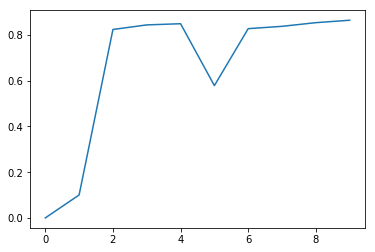

In [14]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
    
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

model.save_params()
plt.plot(acc_list)

1エポック目から急速に正解率を高め，3エポック目ではすでにほとんどの問題に正解できる．  
単純なseq2seqでは10エポックを経過してもほとんど不正解になってしまう．  
Peekyなseq2seqでは4エポック目で正解を出す．  
しかし，時系列データが長くなるに連れて学習の速さだけでなく，精度の点においてもAttentionはPeekySeq2seqより有利になるであろう．  
<br>
ACC1.0はなかなかいかない…何か間違ってる？

## Attentionの可視化
Attentionが時系列変換を行うときにどの要素に注意を払っているのかを可視化する．  
Attentionの重みは，どの文字が別のどの文字に対応しているかを確率分布で示すことができる．  

![Visualization](AUGUSTto08.png)

可視化してみると，seq2seqが
- 「AUGUST」が「08」に対応
- 「1983」が「最初に来る1983」に対応

していることを学習できていることがわかる．  
このことから，seq2seqは我々人間と同じように，必要な情報に注意を向けることができたといえる．  
一般的にニューラルネットワークの内部の処理は理解できないが，Attentionは人間が理解可能な構造や意味をモデルに与えることができる．  

# Attentionに関する残りのテーマ

## 双方向RNN
LSTMの各時刻の隠れベクトルは$hs$にまとめられ，$hs$の各行には対応する単語の成分が多く含まれる．  
このとき，各行の成分には過去の単語の情報も含まれるが，未来の情報もバランスよく含ませたい場合は，**双方向LSTM**(**双方向RNN**)を使う．  
<br>
双方向LSTMのモデルは，順方向の出力に加え，逆方向に時系列データを学習させるTimeLSTMレイヤを追加し，順方向のTimeLSTMレイヤと時刻ごとに連結を行い，$hs$としてまとめて最終的な隠れ状態ベクトルとする．  
なお，連結以外にも「和」や「平均」などを使うこともある．  
実装はcommon/time_layers.pyのTimeBiLSTMクラスにある．

## Attentionレイヤの使用方法
Attentionレイヤを利用する場所は，TimeAffineレイヤとTimeLSTMレイヤの間とは限らない．  
例えば，TimeLSTMの各時刻間にAttentionを挿入することもある.  
どのような構成にすれば精度がよくなるかは，実際のデータをみてみないとわからない．  
どちらかというと我々が実装した方が実装はしやすい．

## seq2seqの深層化とskipコネクション
翻訳などの現実的なアプリケーションでは，問題が複雑になる．  
その場合，Attention付きseq2seqのRNNレイヤを深く重ねることで表現力を高める．  
<br>
一例としてAttentionはDecoderの最初のLSTMと他のLSTMの間に挟んでいるが，複数のAttentionレイヤを使ったり，Attentionの出力を次の時刻のLSTMレイヤへ入力したりと，様々なバリエーションが考えられる．  
しかし，レイヤを深くすると過学習の危険があるので，その場合Dropoutや重み共有などの技術が必要．  
<br>
層を深くするとき，**skipコネクション**というテクニックを使っても過学習を起こしにくくできる.  
これは，層をまたいで先の層の出力に加算するテクニックである．  
逆伝播の時も，足し算の逆伝播はそのまま流して分岐元で加算するだけなので簡単．  
<br>
skipコネクションは，RNNの深さ方向への勾配消失を防ぐのにも有効である，

# Attentionの応用
Attentionというアイデア自体は汎用的であり，さらに多くの可能性を秘めている．  
Attentionを使った最先端の研究例を3つ紹介．

## Google Neural Machine Translation (GNMT)
機械翻訳の歴史
- ルールベース翻訳
- 用例ベース翻訳
- 統計ベース翻訳
- ニューラル翻訳 (Neural Machine Translation) ←

ニューラル翻訳はこれまでの統計翻訳と対比する形で用いられてきたが，最近ではseq2seqを使った機械翻訳の総称として用いられている．  
Google翻訳は2016年からニューラル翻訳が使われており，このシステムはGNMTと呼ばれている．  
GNMTもAttention付きEncoder-Decoderモデルによるseq2seqがベースになっている．  
それに加え，  
- LSTMレイヤの多層化
- Encoderの一層目を双方向LSTM化
- skipコネクション
- 複数GPUでの分散学習
- 程頻出単語の対応
- 推論時の高速化のための量子化

などのテクニックがふんだんに利用されている．  
GNMTは，英語とフランス語やスペイン語の相互翻訳(中国語は人間でも難しい)ではほぼ人間の制度に近づいており，統計ベース機会翻訳の一つである「フレーズベースの機械翻訳」よりも高い制度を実現することができた．  
<br>
しかし，まだまだ不自然な翻訳や，人間ならば発生しないミスも散見される．  
そのため，これから先も機械翻訳の研究は進められていく．  
現在でもニューラル翻訳を中心に活発に研究が行われている．  
<br>
GNMTには100枚近くのGPUを使って6日間の学習を行ったり，8つのモデルを並行して学習するアンサンブル学習を行っていたり，強化学習によってさらなる制度向上を成し遂げる工夫もなされている．  
そのようなことは我々1個人には難しいが，そのコアとなる知識を我々はすでに習得した．

## Transformer
RNNの欠点として，前時刻に計算した結果を用いて逐次的に計算を行うため，並列計算ができないことが挙げられる．  
そのため，現在ではRNNを取り除く，もしくは並列計算可能なRNNの研究が活発に行われている．  
<br>
有名なものに，Transformerモデルと呼ばれるものがあり，「Attention is all you need」という論文で提案された手法である．  
<br>
TransformerモデルはSelf-Attentionというテクニックが使用される点が重要．  
Self-Attentionは，一つの時系列データ内において，各要素が他の要素に対してどのような関連性があるのかを見ていこうというものである．  
通常のAttentionはEncoderからの$hs\_enc$とDecoderのLSTMの出力$hs\_dec$を入力として受け取る．  
一方Self-Attentionは，一つの時系列データ$hs$をコピーし，それぞれに入力する．  
<br>
Transformerモデルでは，TimeLSTM層の代わりにSelf-Attentionが使われる．  
EncoderではFeedFowardレイヤと呼ばれるものを使用する．  
FeedFowardレイヤは，隠れ層が1層で，活性化関数にReLUを用いた全結合のNNである．  
そのようにして作られたEncoder,DecoderをN回，問題によって積み重ね，seq2seqを実現する．
<br>
実際のTransformerモデルでは，そうして作られたモデルに，さらにskipコネクションやLayer Normalization，複数のAttention，Positional Encoding(時系列データの位置情報をエンコード)といった工夫がなされている．
<br>
このようにして計算量を抑え，GPUによる並列計算の恩恵を受けることで学習時間を大幅に減らすことに成功した．  
さらに翻訳制度もGNMTや，CNNを使った翻訳のBLEWスコアという指標で上回った．  
<br>
このように，AttentionはRNNを置き換えるモジュールとして利用することもできる．

Transformer以外にも，RNNをConvolutionレイヤに置き換えてseq2seqを構成し，並列化計算を可能にする研究もある．

## Neural Turing Machine(NTM)
人間が紙とペンを使うように，NNにも外部メモリを利用させることで，さらなる力を付加することができる．  
RNNやLSTMの内部状態，隠れベクトルは固定長であり，詰めこめる情報量には制限があるため，外部記憶に記録するというアプローチが考えられる．  
<br>
Attention付きseq2seqではEncoderは入力文をエンコードし，Decoderがエンコードされた情報を利用していた．  
ここでAttentionはEncoderによって情報を書き込まれ，Decoderによって読み込みを行われていたと考えられる．  
このように，Attentionを使ってコンピュータのメモリ操作をNNによって再現できそうである．  
<br>
そのような研究の中で有名なものとして，**NTM**(Neural Turing Machine)がある．  
NTMはDeepMindのチームによって行われた研究で，後に**DNC**(Differentiable Neural Computers)と呼ばれる手法に改良されている．
<br>
NTMは，コントローラと呼ばれる処理装置(RNNを利用したNN)にメモリを扱えるようにしたものである．  
メモリを扱うのに，必要な情報を書き，不要な情報を消去し，必要な情報を読み込むといった動作が任意の場所で行える．  
NTMは，そのようなメモリ操作を「微分可能」な計算で実現しており，データから手順を学ぶことができる．  
つまり，アルゴリズムの入力と出力から，アルゴリズムやロジック自体を学ぶことができる．
<br>
NTMのレイヤ構成は，大まかにはEncoderのLSTMが「Write head」によってMemoryにデータを書き込み，Decoderはそのメモリから重要なデータを読み込む．  
メモリに対して，ある番地にあるデータを読み書きするときには，「選択」する操作なので，Attentionの時と同じように重みによって選択を行う．  
<br>
NTMが行うメモリ操作には，2つのAttentionを用いる．  
- コンテンツベースのAttention
    - 従来の，クエリベクトルに似たベクトルをメモリから見つけるAttention
- 位置ベースのAttention
    - 前時刻に注目したメモリの位置に対して，その前後に移動するAttention
    - メモリを一つずつ進めながら読んでいくコンピュータ特有の動きを再現しやすくなる

NTMでは他にも，Attentionの重みをシャープにする処理や，前時刻のAttentionの重みを足し合わせる処理などがある．  
<br>
NTMは外部メモリを自由に利用することで，長い時系列を記憶する問題や，ソートの問題を解くことに成功した．  